In [157]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from proj1_helpers import *
from implementations import *
from plots import *
from utils import *
from validation import *
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def remove_outliers(data, parallel_data = None):
    """
    Write docstring later
    NOTE: Outliers were identified previously, via a histogram analysis
    """
    # remove outliers based on the values of the histograms
    data_copy = np.copy(data)
    parallel_copy = np.copy(parallel_data)
    for i, subset in enumerate(data_copy):
        for j in range(subset.shape[1]):
            hist, edges = np.histogram(data[i][:,j])
            try:
                critical = hist.tolist().index(0)
                delete = data[i][:,j] > edges[critical]
                data[i] = np.delete(data[i], delete, axis = 0)
                for index, dataset in enumerate(parallel_copy):
                    parallel_data[index][i] = np.delete(parallel_data[index][i], delete)
            except:
                pass

[False False False ... False  True  True]

[False  True  True ...  True False False]

[ True False False ... False False False]

[False False False ... False False False]



## Load the training data into feature matrix, class labels, and event ids:

In [2]:
import datetime
DATA_TRAIN_PATH = 'data/train.csv' # TODO: download train data and supply path here

labels, input_data, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
# standardize the data : 
x, mean_x, std_x = standardize(input_data)
y, tx = build_model_data(x, labels)

In [4]:
print(f'shape y : {y.shape}, shape x : {tx.shape}')

shape y : (250000,), shape x : (250000, 31)


In [69]:
def preproccess(input_data, labels):
    jets = np.unique(input_data.T[22])
    jet_groups = []
    jet_labels = []
    del_columns = {}
    data_labels = np.concatenate((input_data, labels.reshape(-1, 1)), axis=1)
    for jet in jets:
        del_columns[str(jet)] = []
        jet_group_ = data_labels[data_labels[:, 22] == jet]
        jet_group, jet_label = jet_group_[:, :input_data.shape[1]], jet_group_[:, -1]
        for i in range(len(jet_group[0])):
            if len(np.unique(jet_group[:, i])) == 1:
                del_columns[str(jet)].append(i)
            else:
                jet_group[:, i][jet_group[:, i] == -999] = np.nan
                jet_group[:, i] = np.where(np.isnan(jet_group[:, i]), np.nanmean(jet_group[:, i]), jet_group[:, i])
        for col in del_columns[str(jet)][::-1]:
            jet_group = np.delete(jet_group, col, 1)
        
        jet_groups.append(jet_group)
        jet_labels.append(jet_label)
    return jet_groups, jet_labels, del_columns

In [70]:
jet_groups, jet_labels, del_columns = preproccess(input_data, labels)

In [71]:
means = []
stds = []
for i, (jet_group, jet_label) in enumerate(zip(jet_groups, jet_labels)):
    jet_group, mean_x, std_x = standardize(jet_group)
    means.append(mean_x)
    stds.append(std_x)
    jet_label, jet_group = build_model_data(jet_group, jet_label)
    jet_groups[i] = jet_group
    jet_labels[i] = jet_label
    print(f'jet : {i+1}, shape y : {jet_label.shape}, shape x : {jet_group.shape}')

jet : 1, shape y : (99913,), shape x : (99913, 19)
jet : 2, shape y : (77544,), shape x : (77544, 23)
jet : 3, shape y : (50379,), shape x : (50379, 30)
jet : 4, shape y : (22164,), shape x : (22164, 30)


## Do your thing crazy machine learning thing here :) ...

In [5]:
# #visualize th distribution of the features
# l=[]
# for col_name in df_data.columns: 
#     l.append(col_name)
    
    
# fig, axes = plt.subplots(5, 3, figsize=(20, 20))
# fig.suptitle(
#     "Boxplot distribution of different features of the data"
# )
# sns.boxplot(
#     data=df_data[[l[2], l[3]]], ax=axes[0][0], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[4], l[5]]], ax=axes[0][1], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[6], l[7]]], ax=axes[0][2], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[8], l[9]]], ax=axes[1][0], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[10], l[11]]], ax=axes[1][1], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[12], l[13]]], ax=axes[1][2], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[14], l[15]]], ax=axes[2][0], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[16], l[17]]], ax=axes[2][1], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[18], l[19]]], ax=axes[2][2], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[20], l[21]]], ax=axes[3][0], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[22], l[23]]], ax=axes[3][1], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[24], l[25]]], ax=axes[3][2], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[26], l[27]]], ax=axes[4][0], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[28], l[29]]], ax=axes[4][1], orient="v"
# )
# sns.boxplot(
#     data=df_data[[l[30], l[31]]], ax=axes[4][2], orient="v"
# )
# ;

In [14]:
# splitting data for the training and validation
seed = 46
ratio = 0.8
x_train, y_train, x_test, y_test = split_data(tx, y, ratio=ratio, seed=seed)

In [97]:
# splitting data for the training and validation
seed = 46
ratio = 0.8
x_trains = []
x_tests = []
y_trains = []
y_tests = []
for i, (jet_group, jet_label) in enumerate(zip(jet_groups, jet_labels)):
    x_train, y_train, x_test, y_test = split_data(jet_group, jet_label, ratio=ratio, seed=seed)
    x_trains.append(x_train)
    x_tests.append(x_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

## Least Squares GD

In [116]:
max_iters = 500
gamma = 0.08
initial_w = np.random.rand((x_train.shape[1]))
w, loss = least_squares_GD(y_train, x_train, initial_w, max_iters, gamma, plot_loss = False)

y_pred = predict_labels(w, x_test)
print("accuracy without data preproccessing :", accuracy(y_pred,y_test))

accuracy without data preproccessing : 0.7069704489059327


In [114]:
max_iters = 500
gamma = 0.08
y_preds = []
for i in range(4):
    initial_w = np.random.rand((x_trains[i].shape[1]))
    w, loss = least_squares_GD(y_trains[i], x_trains[i], initial_w, max_iters, gamma, plot_loss = False)

    y_pred = predict_labels(w, x_tests[i])
    y_preds.append(y_pred)

print("accuracy :", accuracy(np.array(np.concatenate(y_preds)), np.array(np.concatenate(y_tests))))

accuracy : 0.744865102697946


### Cross validation for least squares GD

100%|██████████| 10/10 [02:13<00:00, 13.31s/it]


Accuracy is 0.7470


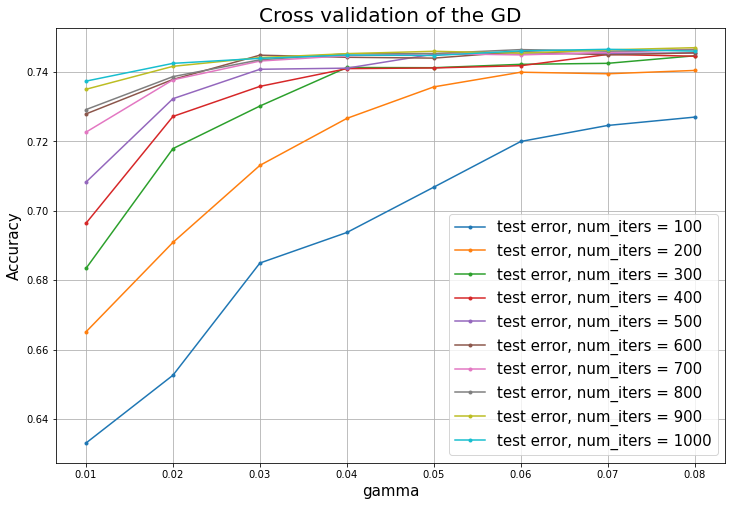

In [111]:
# parameters setting
type_ = 'GD'
bd_left = -2
bd_right = -2
# grid for hyperparameters
gammas = np.linspace(10**bd_left, 8*10**bd_right, 8)
max_iters = np.arange(100, 1100, 100)
cross_validation_demo(type_=type_, y=jet_labels, tx=jet_groups, bd_left=bd_left, bd_right=bd_right, gammas=gammas, max_iters=max_iters, seed=seed)

**Gradient decent converges if gamma < 0.09.  
In this setting the best gamma = 0.08 and the best max_iter = 500.  
Best accutacy = 0.7470**

## Least Squares SGD

In [128]:
max_iters = 500
gamma = 0.08
y_preds = []
for i in range(4):
    initial_w = np.random.rand((x_trains[i].shape[1]))
    w, loss = least_squares_SGD(y_trains[i], x_trains[i], initial_w, max_iters, gamma, plot_loss = False)

    y_pred = predict_labels(w, x_tests[i])
    y_preds.append(y_pred)
              
print("accuracy :", accuracy(np.array(np.concatenate(y_preds)), np.array(np.concatenate(y_tests))))

(19983,)
(15509,)
(10076,)
(4433,)
accuracy : 0.6172276554468911


### Cross validation for least squares SGD

100%|██████████| 5/5 [01:59<00:00, 23.95s/it]


Accuracy is 0.7232


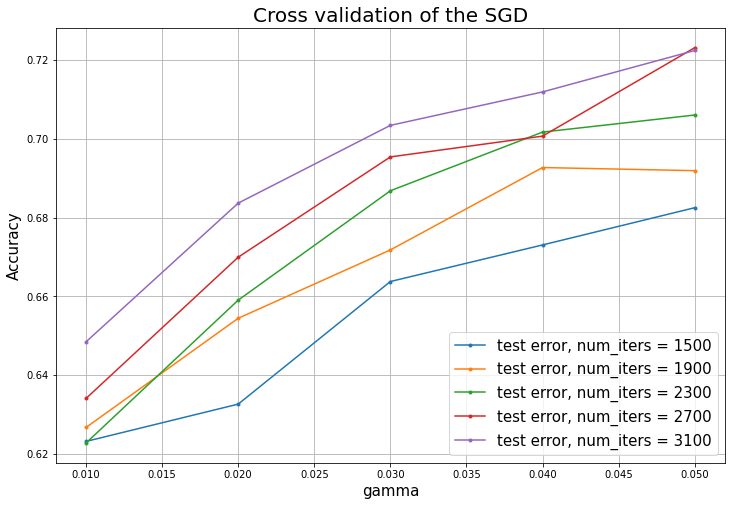

In [120]:
# parameters setting
type_ ='SGD'
bd_left = -2
bd_right = -2
# grid for hyperparameters
gammas = np.linspace(10**bd_left, 8*10**bd_right, 8)
max_iters = np.arange(1500, 3400, 400)
cross_validation_demo(type_=type_, y=jet_labels, tx=jet_groups, bd_left=bd_left, bd_right=bd_right, gammas=gammas, max_iters=max_iters, seed=seed)

## Least Squares

In [131]:
y_preds = []
for i in range(4):
    w, loss = least_squares(y_trains[i], x_trains[i])

    y_pred = predict_labels(w, x_tests[i])
    y_preds.append(y_pred)

print("accuracy :", accuracy(np.array(np.concatenate(y_preds)), np.array(np.concatenate(y_tests))))

accuracy : 0.7587448251034979


## Ridge regression

In [132]:
y_preds = []
for i in range(4):
    w, loss = ridge_regression(y_trains[i], x_trains[i], lambda_=1e-4)
    y_pred = predict_labels(w, x_tests[i])
    y_preds.append(y_pred)
print("accuracy :", accuracy(np.array(np.concatenate(y_preds)), np.array(np.concatenate(y_tests))))

accuracy : 0.7585648287034259


100%|██████████| 2/2 [01:46<00:00, 53.20s/it]


Accuracy is 0.8077


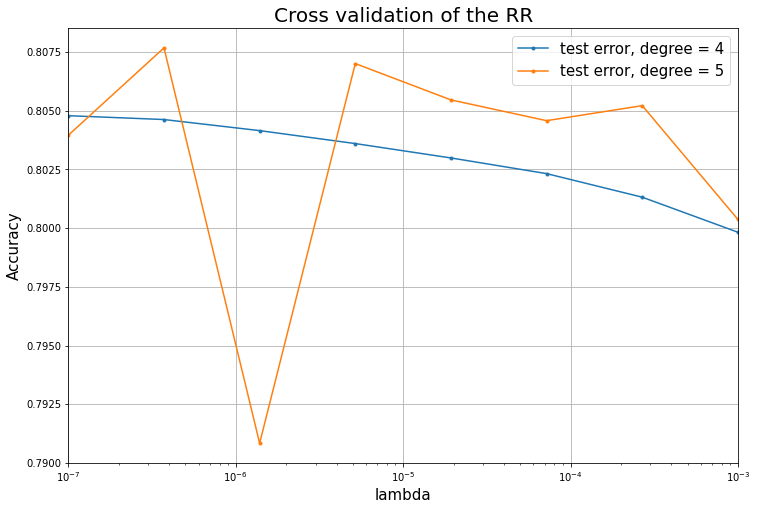

In [137]:
# parameters setting
type_ = 'RR'
bd_left = -7
bd_right = -3
# grid for hyperparameters
lambdas = np.logspace(bd_left, bd_right, 8)
degrees = np.arange(4, 6)
cross_validation_demo(type_=type_, y=jet_labels, tx=jet_groups, bd_left=bd_left, bd_right=bd_right, lambdas=lambdas, degrees=degrees, seed=seed)

In [138]:
# #bias/variance decomposition : 
# def bias_variance_demo():
#     """The entry."""
#     # define parameters
#     seeds = range(100)
#     ratio_train = 0.005
#     lambdas = np.logspace(-7, -3, 10)
#     degree=4
#     # define list to store the variable
#     rmse_tr = np.empty((len(seeds), len(lambdas)))
#     rmse_te = np.empty((len(seeds), len(lambdas)))
#     for index_seed, seed in tqdm(enumerate(seeds)):
#         np.random.seed(seed)
#         # split data with a specific seed
#         x_train,y_train,x_test,y_test = split_data(tx, y, ratio_train, seed)
#         if degree == 0:
#             x_train_phi =  x_train
#             x_test_phi  =  x_test
#         else:
#             x_train_phi =  build_poly(x_train,degree)
#             x_test_phi  =  build_poly(x_test,degree)
#         for index_degree,lambda_ in enumerate(lambdas) :
#             w_tr,_ = ridge_regression(y_train,x_train_phi,lambda_)
#             rmse_te[index_seed,index_degree] = np.sqrt(2*compute_mse(y_test,x_test_phi,w_tr))
#             rmse_tr[index_seed,index_degree] = np.sqrt(2*compute_mse(y_train,x_train_phi,w_tr))
#         # bias_variance_decomposition
#     bias_variance_decomposition_visualization(lambdas, rmse_tr, rmse_te)

# bias_variance_demo()

## Logistic Regression

In [146]:
max_iters = 500
gamma = 0.1
y_preds = []
for i in range(4):
    initial_w = np.random.rand((x_trains[i].shape[1]))
    w, loss = logistic_regression(y_trains[i], x_trains[i], initial_w, max_iters, gamma, plot_loss = False)
    y_pred = predict_labels_lr(w, x_tests[i])
    y_preds.append(y_pred)
              
print("accuracy :", accuracy(np.array(np.concatenate(y_preds)), np.array(np.concatenate(y_tests))))

accuracy : 0.7361052778944421


### Cross validation for logistic regression

100%|██████████| 3/3 [03:51<00:00, 77.08s/it]


Accuracy is 0.7452


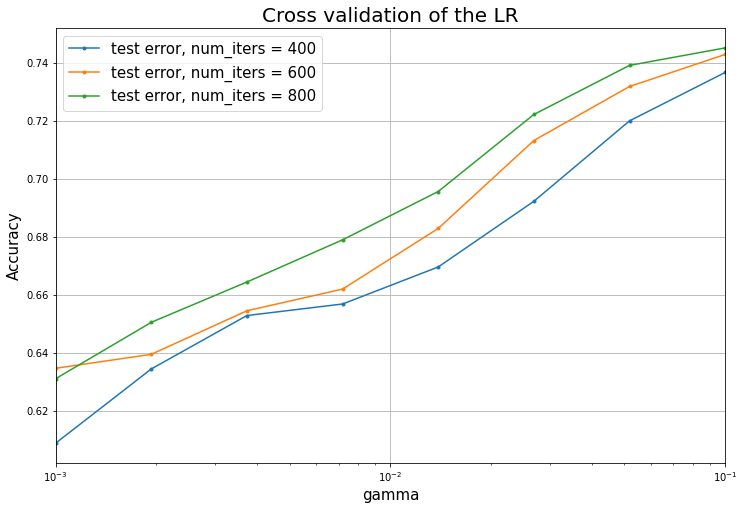

In [143]:
# parameters setting
type_ = 'LR'
bd_left = -3
bd_right = -1
# grid for hyperparameters
# gammas = np.linspace(10**bd_left, 10**bd_right, 10)
gammas = np.logspace(bd_left, bd_right, 8)
max_iters = np.arange(400, 1000, 200)
cross_validation_demo(type_=type_, y=jet_labels, tx=jet_groups, bd_left=bd_left, bd_right=bd_right, gammas=gammas, max_iters=max_iters, seed=seed)

## Logistic Regression with Regularization

In [164]:
max_iters = 800
gamma = 0.1
lambda_ = 1e-5
y_preds = []
w_lrr = []
for i in range(4):
    initial_w = np.random.rand((x_trains[i].shape[1]))
    w, loss = reg_logistic_regression(y_trains[i], x_trains[i], lambda_, initial_w, max_iters, gamma, plot_loss = False)
    y_pred = predict_labels(w, x_tests[i])
    y_preds.append(y_pred)
    w_lrr.append(w)
              
print("accuracy :", accuracy(np.array(np.concatenate(y_preds)), np.array(np.concatenate(y_tests))))

accuracy : 0.7452650946981061


### Cross validation for logistic regression with regularizarion

100%|██████████| 3/3 [03:02<00:00, 60.99s/it]


Accuracy is 0.7429


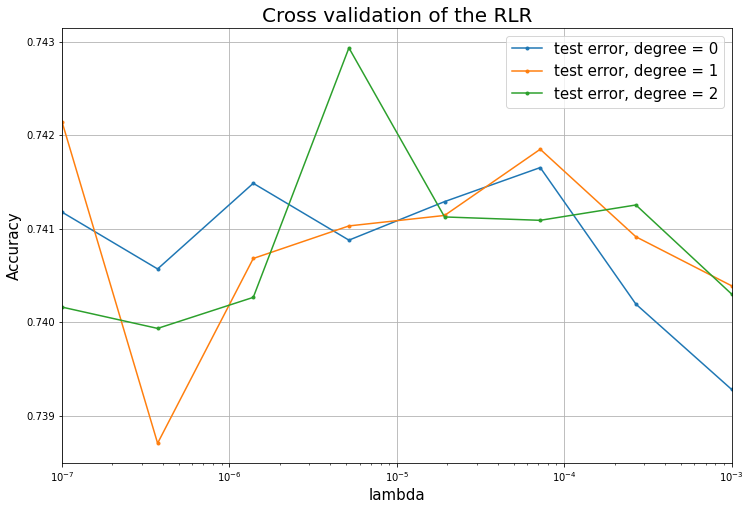

In [150]:
# parameters setting
type_ = 'RLR'
bd_left = -7
bd_right = -3
max_iters = 500
gammas = 0.1
# grid for hyperparameters
lambdas = np.logspace(bd_left, bd_right, 8)
degrees = np.arange(3)
cross_validation_demo(type_=type_, y=jet_labels, tx=jet_groups, bd_left=bd_left, bd_right=bd_right, lambdas=lambdas, degrees=degrees, max_iters=max_iters, gammas=gammas, seed=seed)

# 2. Confusion matrix 

Text(51.0, 0.5, 'expected')

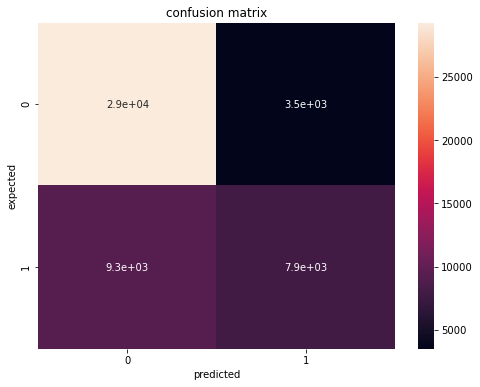

In [153]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
#confusion matrix
fig, ax = plt.subplots(figsize = (8, 6))
cm = confusion_matrix(np.array(np.concatenate(y_tests)), np.array(np.concatenate(y_preds)), labels = [-1.0, 1.0])
sn.heatmap(cm, annot = True, axes = ax)
plt.title("confusion matrix")
plt.xlabel("predicted")
plt.ylabel("expected")


# 5. Improvements : PCA


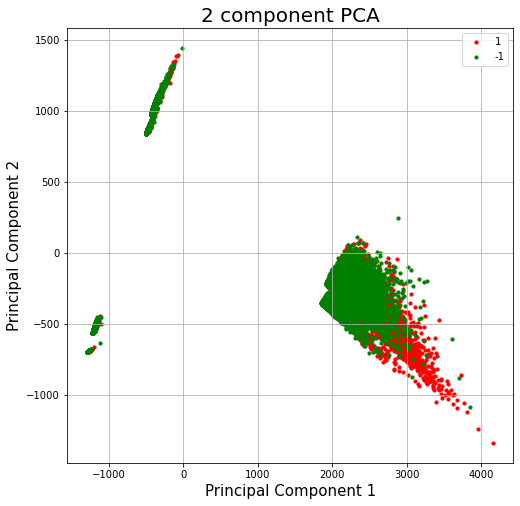

In [70]:
#PCA 2D  : 
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(input_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df_target=pd.DataFrame(y,columns=['target'])
finalDf = pd.concat([principalDf, df_target], axis = 1)
df_target.head()

fig= plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
#ax.set_zlabel('Principal Component 3', rotation=90)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, -1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               #, finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

<Figure size 480x480 with 0 Axes>

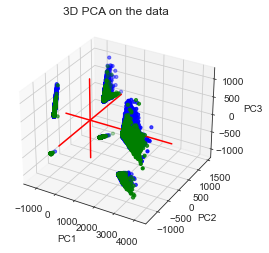

In [83]:
#PCA 3D :
# Get the iris dataset
sns.set_style("white")

# create figure
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
 
# Run The PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(input_data)
principalDf = pd.DataFrame(data = principalComponents
                           , columns = ['principal component 1', 'principal component 2','principal component 3'])
df_target=pd.DataFrame(y,columns=['target'])
finalDf = pd.concat([principalDf, df_target], axis = 1)
 
# Store results of PCA in a data frame
 
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

targets = [1, -1]
colors = ['g', 'b']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               #, finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 10)

 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA on the data")
plt.show()

## Generate predictions and save ouput in csv format for submission:

In [50]:
DATA_TEST_PATH = 'data/test.csv'  # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [220]:
def preproccess_test(input_data, ids_test, del_columns):
    jets = np.unique(input_data.T[22])
    jet_groups = []
    jet_idxs = []
    data_labels = np.concatenate((input_data, ids_test.reshape(-1, 1)), axis=1)
    for i, jet in enumerate(jets):
        jet_group_ = data_labels[data_labels[:, 22] == jet]
        jet_group, jet_idx = jet_group_[:, :input_data.shape[1]], jet_group_[:, -1]
        for col in del_columns[str(jet)][::-1]:
            jet_group = np.delete(jet_group, col, 1)
        jet_group = (jet_group - means[i])/stds[i]
#         jet_group = np.c_[np.ones(jet_group.shape[0]), jet_group]
        
        jet_group = np.concatenate((np.ones(jet_group.shape[0]).reshape(-1, 1), jet_group), axis=1)
#         jet_group = np.hstack((np.ones(jet_group.shape[0]), jet_group))
        
        jet_groups.append(jet_group)
        jet_idxs.append(jet_idx)
    jet_idxs = np.array(np.concatenate(jet_idxs))
    return jet_groups, jet_idxs

In [221]:
jet_groups_test, jet_idxs = preproccess_test(tX_test, ids_test, del_columns)

In [228]:
y_preds = []
for i in range(4):
    y_pred = predict_labels(w_lrr[i], jet_groups_test[i])
    y_preds.append(y_pred)
final_pred = np.array(np.concatenate(y_preds))

(227458,)
(175338,)
(114648,)
(50794,)


In [230]:
OUTPUT_PATH = 'data/pred.csv' # TODO: fill in desired name of output file for submission
create_csv_submission(jet_idxs, final_pred, OUTPUT_PATH)